视觉几何组 Visual Geometry Group

##### 经典卷积神经网络的基本组成部分是下面的这个序列：

- 带填充以保持分辨率的卷积层；

- 非线性激活函数，如ReLU；

- 汇聚层，如最大汇聚层。

而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

In [4]:
def vgg_block(num_convs,in_channels,out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
                     )
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2)) 
    return nn.Sequential(*layers)


# conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数

# 原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 
# 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。
# 由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11
conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))

In [5]:
# vgg-11

def vgg(conv_arch):
    conv_blks=[]
    in_channels=1
    
    # 卷积部分
    for (num_convs,out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels=out_channels
        
    # 全链接部分
    return nn.Sequential(
        *conv_blks,
        nn.Flatten(),
        nn.Linear(out_channels*7*7,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,10)
                     )

net=vgg(conv_arch)

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
device=torch.device('mps')

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)


Traceback (most recent call last):
  File "/Users/hailin/opt/anaconda3/envs/d2l/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/hailin/opt/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/hailin/opt/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/hailin/opt/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

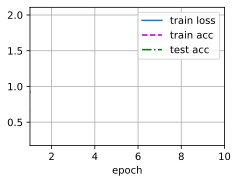

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

- VGG-11使用可复用的卷积块构造网络。不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义。

- 块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。

- 在VGG论文中，Simonyan和Ziserman尝试了各种架构。特别是他们发现深层且窄的卷积（即）比较浅层且宽的卷积更有效。